# DCNet - A simple LSTM-RNN for generating sequence consensus II

This is the second part of the DCNet notebook. The general DCNet setup and training is the same as part I, but we are training the DCNet taking two sets of noisy sequences instead of one.  

In [1]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

torch.manual_seed(42)

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

Here we define the simple DCNet class as subclass of `torch.nn.Module`.

In [3]:
class DCNet(nn.Module):

    def __init__(self, hidden_dim, layer1_dim, layer2_dim):
        super(DCNet, self).__init__()
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(4, hidden_dim) 
        self.linear1 = nn.Linear(hidden_dim, layer1_dim)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(layer1_dim, layer2_dim)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(layer2_dim, 4)
        self.hidden_init_values = None
        self.hidden = self.init_hidden()
        nn.init.xavier_uniform(self.linear1.weight)
        nn.init.xavier_uniform(self.linear2.weight)
        nn.init.xavier_uniform(self.linear3.weight)
        
    def init_hidden(self):
        if self.hidden_init_values == None:
            self.hidden_init_values = (autograd.Variable(torch.randn(1, 1, self.hidden_dim)),
                                       autograd.Variable(torch.randn(1, 1, self.hidden_dim)))
        return self.hidden_init_values

    def forward(self, seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq), 1, -1), self.hidden)
        tmp1 = self.relu1(self.linear1(lstm_out.view(len(seq), -1)))
        tmp2 = self.relu2(self.linear2(tmp1))
        _out = self.linear3(tmp2)
        base_out = _out
        return base_out


We define a couple utility functions for encoding DNA bases to vectors and simulate sequencing errors.

In [4]:
import random
torch.set_default_tensor_type('torch.cuda.FloatTensor')

bmap = {"A":0, "C":1, "G":2, "T":3}
def one_hot(b):
    t = [[0,0,0,0]]
    i = bmap[b]
    t[0][i] = 1
    return t

print("one-hot encoding for DNA bases")
print("A:", one_hot("A"))
print("C:", one_hot("C"))
print("G:", one_hot("G"))
print("T:", one_hot("T"))


one-hot encoding for DNA bases
A: [[1, 0, 0, 0]]
C: [[0, 1, 0, 0]]
G: [[0, 0, 1, 0]]
T: [[0, 0, 0, 1]]


In [5]:
def sim_error(seq, pi=0.05, pd=0.05, ps=0.01):
    """
    Given an input sequence `seq`, generating another
    sequence with errors. 
    pi: insertion error rate
    pd: deletion error rate
    ps: substitution error rate
    """
    out_seq = []
    for c in seq:
        while 1:
            r = random.uniform(0,1)
            if r < pi:
                out_seq.append(random.choice(["A","C","G","T"]))
            else:
                break
        r -= pi
        if r < pd:
            continue
        r -= pd
        if r < ps:
            out_seq.append(random.choice(["A","C","G","T"]))
            continue
        out_seq.append(c)
    return "".join(out_seq)

Generate a random sequence of length 220 as our original teamplate sequences.

In [6]:
seq1 = list("AAAAAAA")+[random.choice(["A","C","G","T"]) for _ in range(220)]
print("seq1", "".join(seq1))
# convert the `seq` to a PyTorch tensor
print()
seq2 = list("TTTTTTT")+[random.choice(["A","C","G","T"]) for _ in range(220)]
print("seq2", "".join(seq2))
# convert the `seq` to a PyTorch tensor

seq1 AAAAAAATTCAAACATCCGTGTCCACTATGCTATATAGCCGTTGGACGTGGTCTTCTCCGGTGGTTGTCTTGAACACTCTAGTGCCTTGACTGATTCCACCAGGACTCCCAAAGAATAACACTGTTTGAACCAAGTCCGTTTCCAGTACCTATCAACTCGGTAGGTCGCGTGAGGCGCGCAGGAGTGAATGAACGAGATAGTGCAAATTCGTAGTCGGCCGTATCCG

seq2 TTTTTTTAACCCTCAAGAAGATGTCGTTTGTTGGAGGTCTGCTCATGCAACGCGTCTACAAGCCCCAACTCACGTCGTCACGCACGTTGTGTCCTCCGGATTCTGTAATCCCCACGTGAGTGACCGCAGTAATGCAGGCTAACCCGTAAGGCCTGTAGCACTTGGACATATCTATCCGTATGGTGGGTGCCGGATGGTGTTAATTGGCTTACGCTTCTATTACCAGC


In [7]:
seq1_t = Variable(torch.FloatTensor([one_hot(c) for c in seq1])).cuda()
seq2_t = Variable(torch.FloatTensor([one_hot(c) for c in seq2])).cuda()

Simulate 20 erroneous sequences with just subsitution error at 5%. I can't get the network trained reliably to converge for other higher error rates yet. Certainly, it will need more research work to have a more robust network and procedure for training.  What shonwn in this notework is just a quick demostration and I think it will need to adjust the network architecture quite a bit for using LSTM-RNN for multiple sequence case.

In [8]:
seqs1 = [sim_error(seq1, pi=0.00, pd=0.00, ps=0.05) for _ in range(30)]
seqs2 = [sim_error(seq2, pi=0.00, pd=0.00, ps=0.05) for _ in range(30)]
seqs_all_t= [Variable(torch.FloatTensor([one_hot(c) for c in s])).cuda() for s in seqs1+seqs2]

Initialize the DCNet.

In [9]:
dcnet = DCNet(32, 12, 12)
dcnet.cuda()
dcnet.zero_grad()
dcnet.hidden = dcnet.init_hidden()

# initial the paramerters in the DCNet
for name, param in dcnet.named_parameters():
    if 'bias' in name:
        nn.init.constant(param, 0.0)
    elif 'weight' in name:
        nn.init.xavier_normal(param)

Set up the loss function and SGD optimizer.

In [10]:
#loss_function = nn.L1Loss()
loss_function = nn.MSELoss()
lr = 0.1
optimizer = optim.SGD(dcnet.parameters(), lr=lr)

The following loop train the DCnet using the noisy sequences. We also lowe the learning rate `lr` every 250 epoches

In [11]:
range_ = (1, 200)
mini_batch_size = 5
for epoch in range(3000):
    for i in range(int(len(seqs_all_t)/mini_batch_size)):
        loss = 0
        s, e = range_
        for tmp_seq in random.sample(seqs_all_t, mini_batch_size):
            dcnet.hidden = dcnet.init_hidden()
            dcnet.zero_grad()
            tmp_seq = tmp_seq[s-1:e]
            seq_ = tmp_seq.view(-1,4)
            out = dcnet(seq_)
            loss += loss_function(out[:-1], seq_[1:])
        loss.backward()
        optimizer.step()
    if epoch % 250==0:
        print("epoch:", epoch, "loss:", loss.cpu().data[0]/mini_batch_size, "learning rate:", lr)
        lr *= 0.95
        optimizer = optim.SGD(dcnet.parameters(), lr=lr)

epoch: 0 loss: 0.18801305294036866 learning rate: 0.1
epoch: 250 loss: 0.15969973802566528 learning rate: 0.095
epoch: 500 loss: 0.10751837491989136 learning rate: 0.09025
epoch: 750 loss: 0.17705023288726807 learning rate: 0.0857375
epoch: 1000 loss: 0.09085813760757447 learning rate: 0.08145062499999998
epoch: 1250 loss: 0.0663881778717041 learning rate: 0.07737809374999999
epoch: 1500 loss: 0.05792460441589355 learning rate: 0.07350918906249998
epoch: 1750 loss: 0.1442936420440674 learning rate: 0.06983372960937498
epoch: 2000 loss: 0.1121256947517395 learning rate: 0.06634204312890622
epoch: 2250 loss: 0.10280588865280152 learning rate: 0.0630249409724609
epoch: 2500 loss: 0.09486528038978577 learning rate: 0.05987369392383786
epoch: 2750 loss: 0.09233986139297486 learning rate: 0.05688000922764597


We can visualize the input and output tensors after we send the whole original template into the DCNet to reconstruct the output tensor from the first sequences.

In [12]:
import numpy as np
dcnet.hidden = dcnet.init_hidden()
xout = dcnet(seq1_t[:250])
x1 = xout[:-1].cpu().data.numpy() 
xx1=np.transpose(seq1_t[1:250,0,:].data.cpu().numpy())
xx2=np.transpose(x1)


The cell below plots three matrices. The first one is from the original template. The second one is the reconstruction from the the DCNet using the whole initial template as input. The third one is the differece between the two matrices. In some cases, if the training of the DCNet is not properly conveged, you might see a lot of spot lighting up in the third matrix.

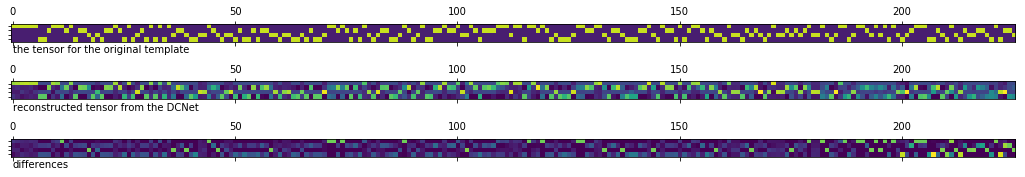

In [13]:
plt.figure(figsize=(18,3))
plt.subplot(3,1,1)
plt.matshow(xx1, vmin=-0.1, vmax=1.1, fignum=False)
plt.text(0,6,"the tensor for the original template")
frame = plt.gca()
frame.axes.yaxis.set_ticklabels([])

plt.subplot(3,1,2)
plt.matshow(xx2, vmin=-0.1, vmax=1.1, fignum=False)
plt.text(0,6,"reconstructed tensor from the DCNet")
frame = plt.gca()
frame.axes.yaxis.set_ticklabels([])

plt.subplot(3,1,3)
plt.matshow(xx1-xx2, vmin=-0.1, vmax=1.1, fignum=False)
plt.text(0,6,"differences");
frame = plt.gca()
frame.axes.yaxis.set_ticklabels([]);

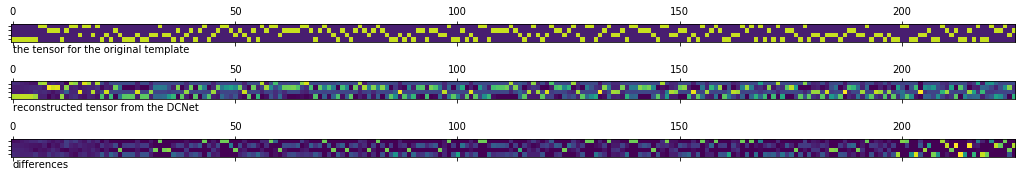

In [14]:
dcnet.hidden = dcnet.init_hidden()
xout = dcnet(seq2_t[:250])
x1 = xout[:-1].cpu().data.numpy() 
xx1=np.transpose(seq2_t[1:250,0,:].data.cpu().numpy())
xx2=np.transpose(x1)

plt.figure(figsize=(18,3))
plt.subplot(3,1,1)
plt.matshow(xx1, vmin=-0.1, vmax=1.1, fignum=False)
plt.text(0,6,"the tensor for the original template")
frame = plt.gca()
frame.axes.yaxis.set_ticklabels([])

plt.subplot(3,1,2)
plt.matshow(xx2, vmin=-0.1, vmax=1.1, fignum=False)
plt.text(0,6,"reconstructed tensor from the DCNet")
frame = plt.gca()
frame.axes.yaxis.set_ticklabels([])

plt.subplot(3,1,3)
plt.matshow(xx1-xx2, vmin=-0.1, vmax=1.1, fignum=False)
plt.text(0,6,"differences");
frame = plt.gca()
frame.axes.yaxis.set_ticklabels([]);

The following code snippet using DCNet to generate a consensus sequence with only the first base in the template. 

In [15]:
dcnet.hidden = dcnet.init_hidden()
base_t= Variable(torch.FloatTensor([one_hot(c) for c in seq1[:5]])).cuda()

consensus = []

for _ in range(201):
    xout = dcnet(base_t)
    next_t = [0,0,0,0]
    next_t[np.argmax(xout.cpu().data.numpy()[-1])]=1
    consensus.append(next_t)
    base_t= Variable(torch.FloatTensor([next_t])).cuda()
    
consensus = np.array(consensus)
consensus = consensus.transpose()

Let's compare the generated consensus to the original template. If we have generate the consensus perfectly matching the original template, the elements of the third matrix will be all zeros (blue color).

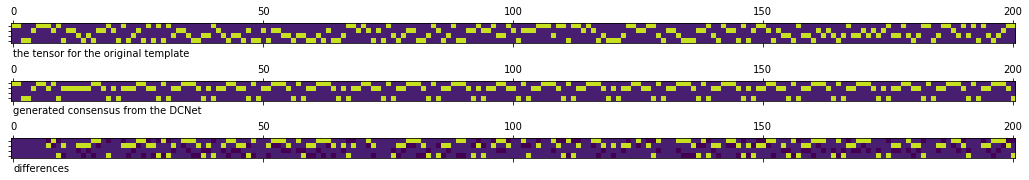

In [16]:
xx1=np.transpose(seq1_t[5:250,0,:].data.cpu().numpy())

plt.figure(figsize=(18,3))
plt.subplot(3,1,1)
plt.matshow(xx1[:,0:201], vmin=-0.1, vmax=1.1, fignum=False)
plt.text(0,6,"the tensor for the original template")
frame = plt.gca()
frame.axes.yaxis.set_ticklabels([])

plt.subplot(3,1,2)
plt.matshow(consensus, vmin=-0.1, vmax=1.1, fignum=False)
plt.text(0,6,"generated consensus from the DCNet")
frame = plt.gca()
frame.axes.yaxis.set_ticklabels([])

plt.subplot(3,1,3)
plt.matshow(consensus-xx1[:,0:201], vmin=-0.1, vmax=1.1, fignum=False)
plt.text(0,6,"differences")
frame = plt.gca()
frame.axes.yaxis.set_ticklabels([]);

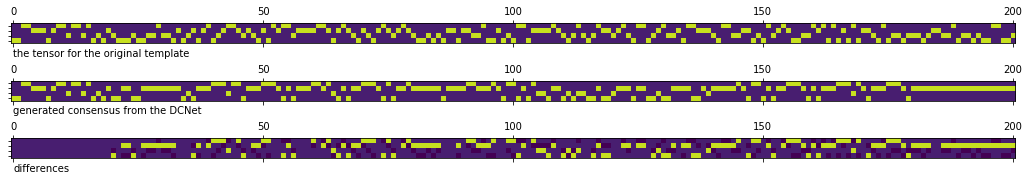

In [17]:
dcnet.hidden = dcnet.init_hidden()
base_t= Variable(torch.FloatTensor([one_hot(c) for c in seq2[:5]])).cuda()

consensus = []

for _ in range(201):
    xout = dcnet(base_t)
    next_t = [0,0,0,0]
    next_t[np.argmax(xout.cpu().data.numpy()[-1])]=1
    consensus.append(next_t)
    base_t= Variable(torch.FloatTensor([next_t])).cuda()
    
consensus = np.array(consensus)
consensus = consensus.transpose()


xx1=np.transpose(seq2_t[5:250,0,:].data.cpu().numpy())

plt.figure(figsize=(18,3))
plt.subplot(3,1,1)
plt.matshow(xx1[:,0:201], vmin=-0.1, vmax=1.1, fignum=False)
plt.text(0,6,"the tensor for the original template")
frame = plt.gca()
frame.axes.yaxis.set_ticklabels([])

plt.subplot(3,1,2)
plt.matshow(consensus, vmin=-0.1, vmax=1.1, fignum=False)
plt.text(0,6,"generated consensus from the DCNet")
frame = plt.gca()
frame.axes.yaxis.set_ticklabels([])

plt.subplot(3,1,3)
plt.matshow(consensus-xx1[:,0:201], vmin=-0.1, vmax=1.1, fignum=False)
plt.text(0,6,"differences")
frame = plt.gca()
frame.axes.yaxis.set_ticklabels([]);

Jason Chin, Mar. 2018